# Проект: классификация

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE

import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### целевая переменная
deposit (определяет, согласится ли клиент открыть депозит в банке)

### Задание 1

In [324]:
df = pd.read_csv('data/bank_fin.zip', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [326]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [327]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

### Задание 3

In [328]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def get_num(arg):
    arg = str(arg).replace(' ', '').replace(',', '.').replace('$', '')
    return float(arg)

df.balance = df.balance.apply(get_num)


In [329]:
print('Среденее значение баланса счёта равно {:.3f}'.format(df.balance.mean()))

Среденее значение баланса счёта равно 1529.129


### Задание 4

In [330]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.balance = df.balance.fillna(df.balance.median())
df.balance.isnull().sum()

0

In [331]:
print('Среденее значение баланса счёта равно {:.3f}'.format(df.balance.mean()))

Среденее значение баланса счёта равно 1526.936


### Задание 5

In [332]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.job = df.job.replace('unknown', np.nan)
df.education = df.education.replace('unknown', np.nan)

df.job = df.job.fillna(value=df.job.mode()[0])
df.education = df.education.fillna(value=df.education.mode()[0])

# 
print('Среденее значение баланса счёта равно {:.3f}'.format(df[(df.job == df.job.mode()[0])&(df.education == df.education.mode()[0])].balance.mean()))

Среденее значение баланса счёта равно 1598.883


### Задание 6

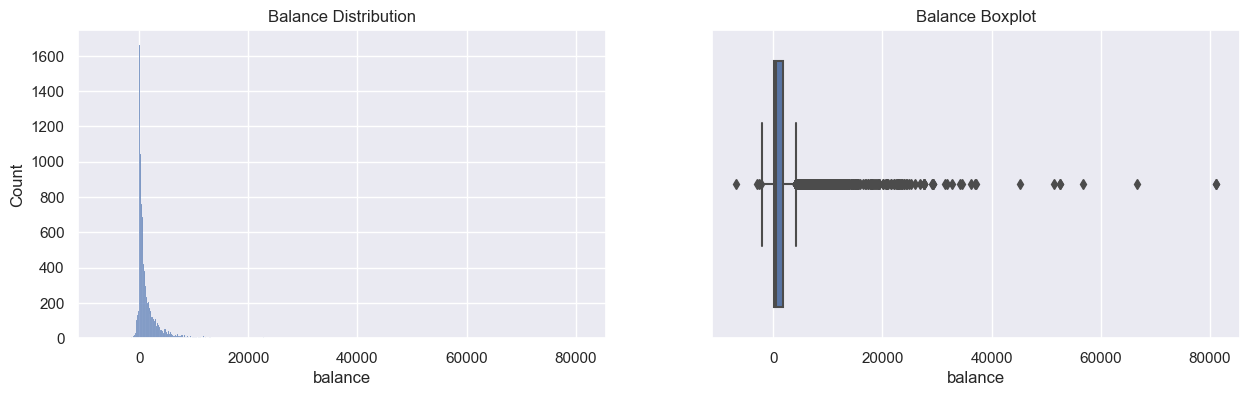

In [333]:
# проверить распределеие признака 'balance'

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1], orient='h');
boxplot.set_title('Balance Boxplot');

In [334]:
# найти и избавиться от выбросов в признаке 'dalance', приведя его распределение к нормальному
outliers, cleaned = find_outliers_iqr(df, 'balance', left=1.5, right=1.5, log_scale=True)

cleaned.shape[0]

9563

In [335]:
# найти и избавиться от выбросов в признаке 'balance', оставиив логнормальное распределение

quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
iqr = quartile_3 - quartile_1
lower_bound = quartile_1 - (iqr * 1.5)
upper_bound = quartile_3 + (iqr * 1.5)
df = df[(x >= lower_bound) & (x <= upper_bound)]

print(f'Нижняя граница {lower_bound}')
print(f'Верхняя граница {upper_bound}')
print(f'Осталось объектов {df.shape[0]}')

Нижняя граница -2241.0
Верхняя граница 4063.0
Осталось объектов 10105


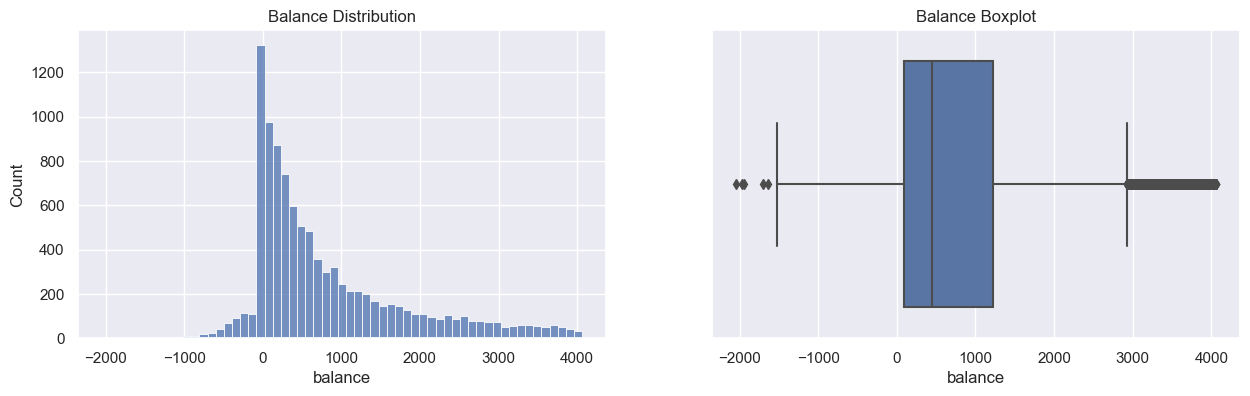

In [336]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Balance Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1], orient='h');
boxplot.set_title('Balance Boxplot');

## Часть 2:  Разведывательный анализ

### Задание 1

Количество клиентов, открывших депозит = 4681


no     5424
yes    4681
Name: deposit, dtype: int64

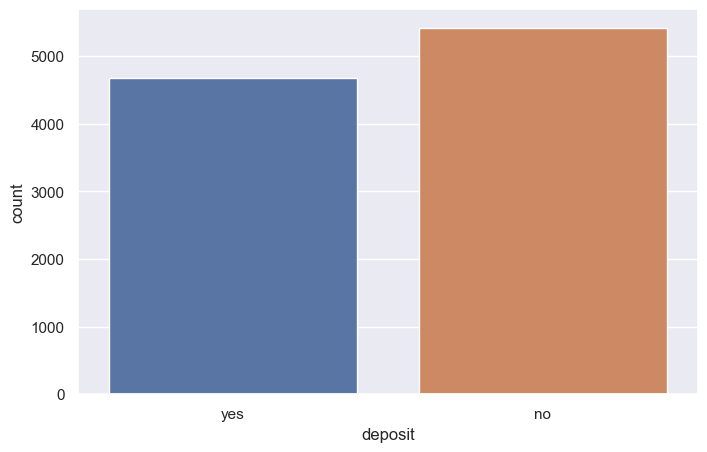

In [337]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.set(rc = {'figure.figsize':(8,5)})
sns.countplot(data=df, x='deposit');

print(f'Количество клиентов, открывших депозит = {df.deposit.value_counts()[1]}')

df.deposit.value_counts()

### Задания 2 и 3

In [338]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [339]:
df['deposit'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

,job,marital,education,default,housing,loan,contact,month,poutcome
count,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4
top,management,married,secondary,no,no,no,cellular,may,unknown
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570


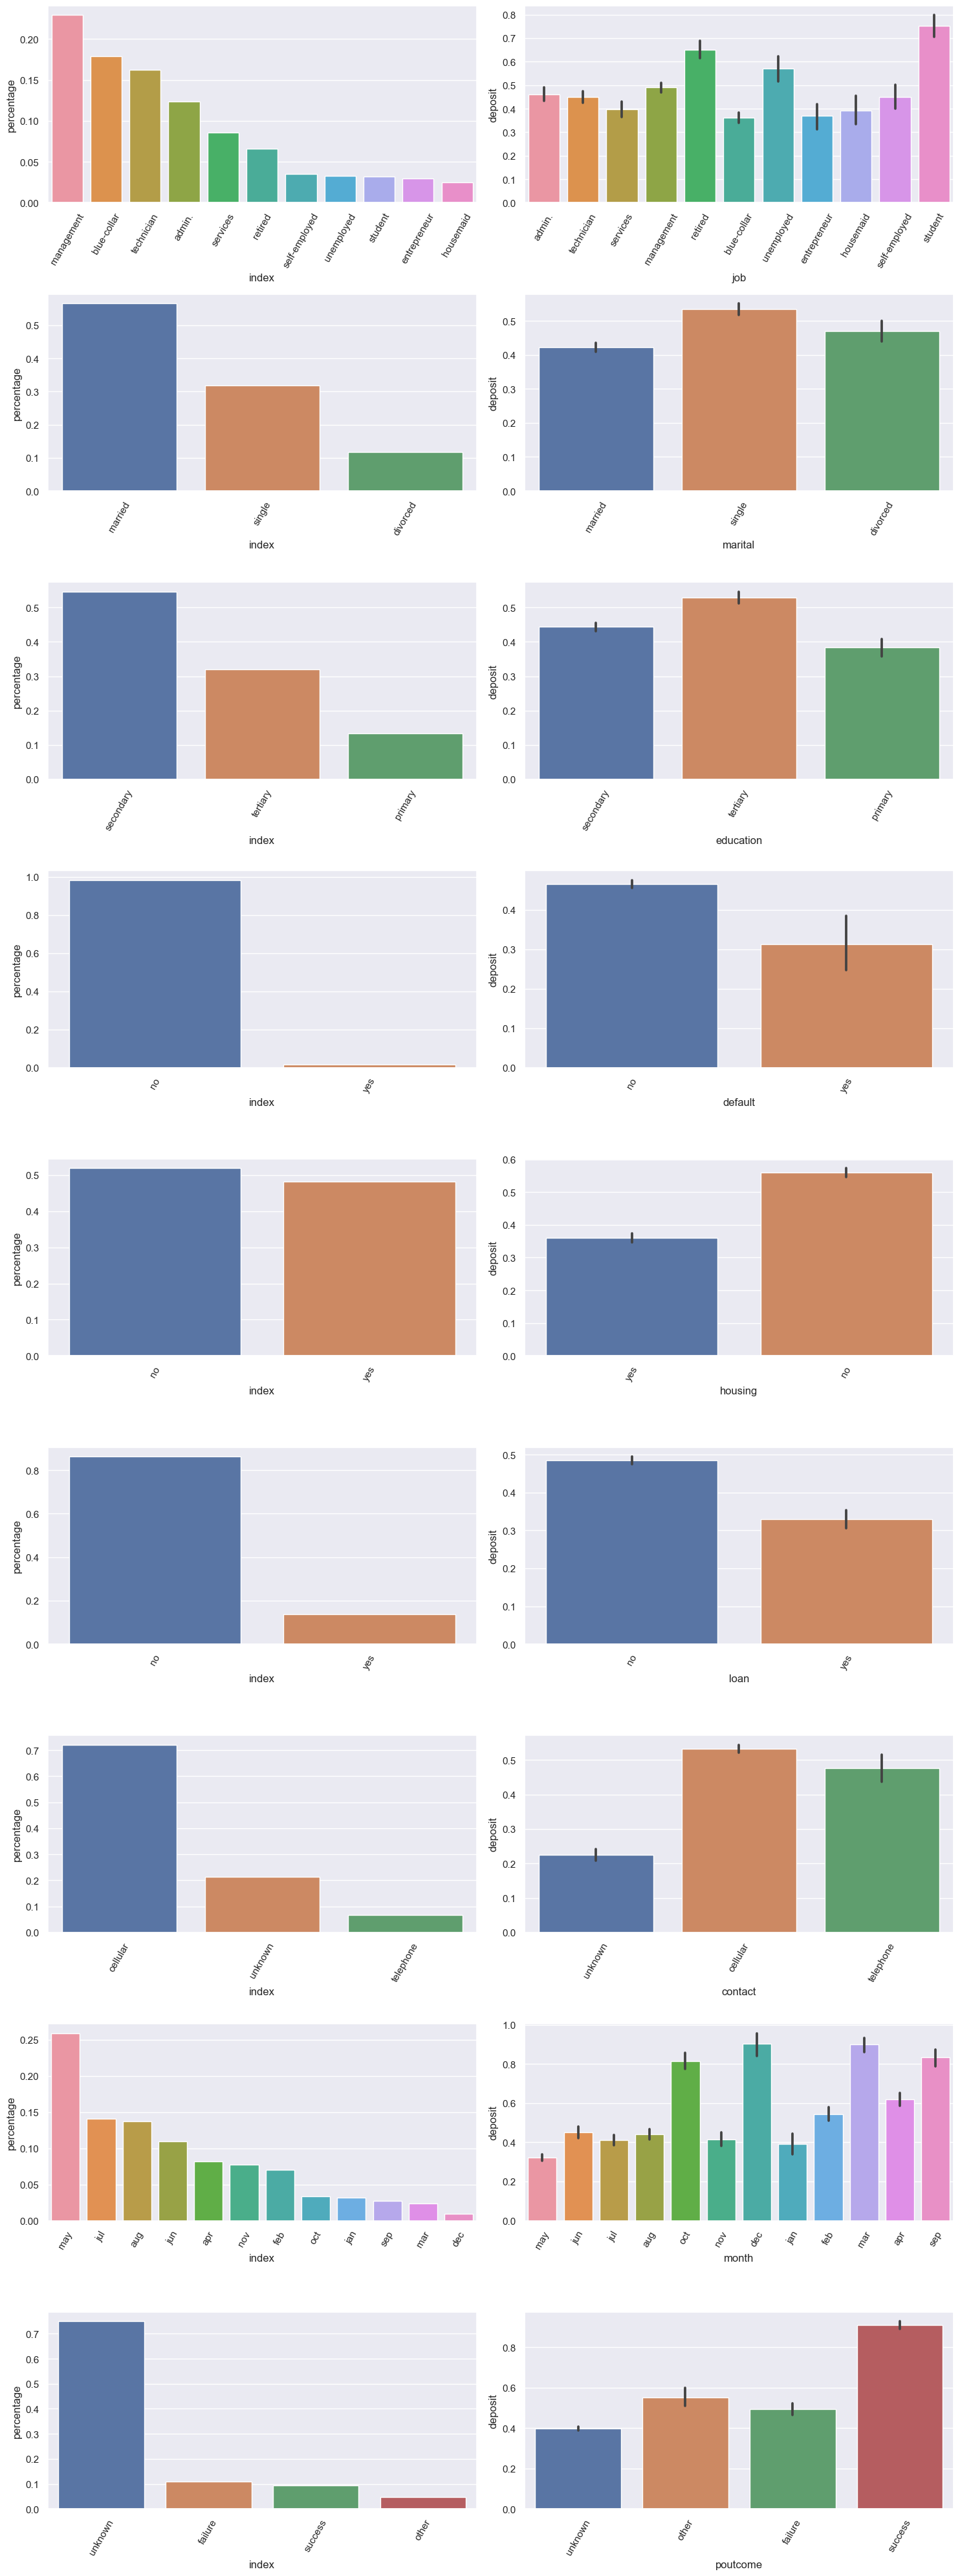

In [340]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(df.describe(include='object'))
#постройте визуализации, иллюстрирующие результаты
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей зарабатывающих >50K (среднее по столбцу income) в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

deposit,0,1
poutcome,,
failure,0.506763,0.493237
other,0.449064,0.550936
success,0.088889,0.911111
unknown,0.602642,0.397358


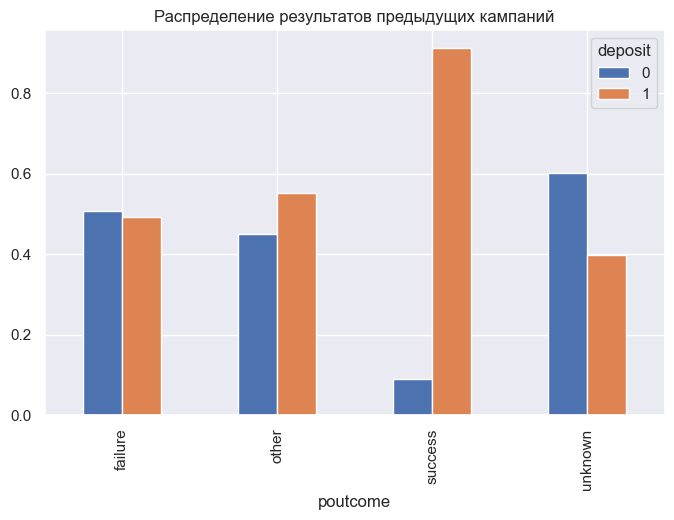

In [341]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
campaign = df.groupby('poutcome').deposit.value_counts(normalize=True).unstack()
display(campaign)

campaign.plot(kind='bar', title='Распределение результатов предыдущих кампаний', figsize=(8, 5));

### Задание 7

deposit,0,1
month,,
apr,0.381928,0.618072
aug,0.559567,0.440433
dec,0.096774,0.903226
feb,0.455571,0.544429
jan,0.608150,0.391850
jul,0.589563,0.410437
jun,0.548913,0.451087
mar,0.101266,0.898734
may,0.678640,0.321360


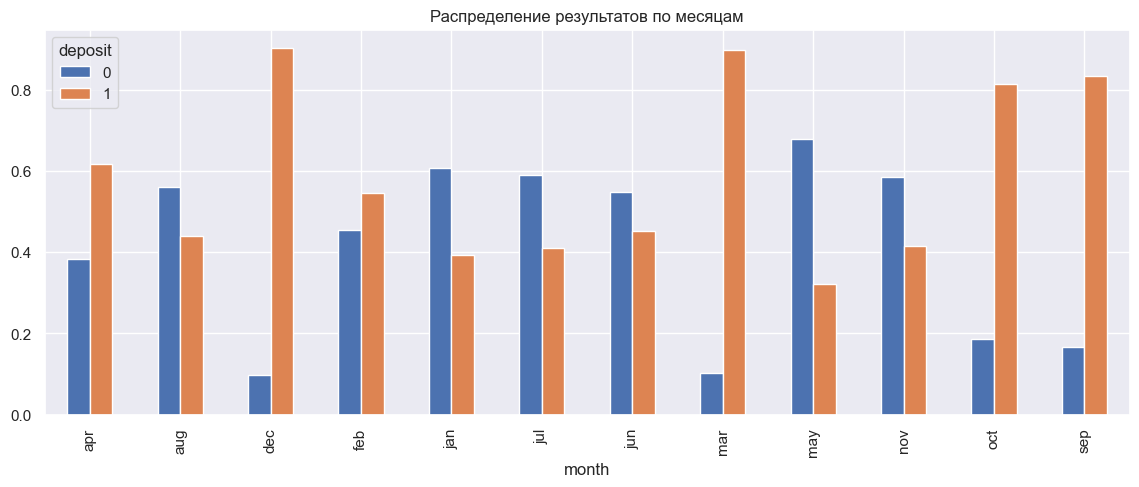

In [342]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
months = df.groupby('month').deposit.value_counts(normalize=True).unstack()
display(months)

months.plot(kind='bar', title='Распределение результатов по месяцам', figsize=(14, 5));

### Задание 8

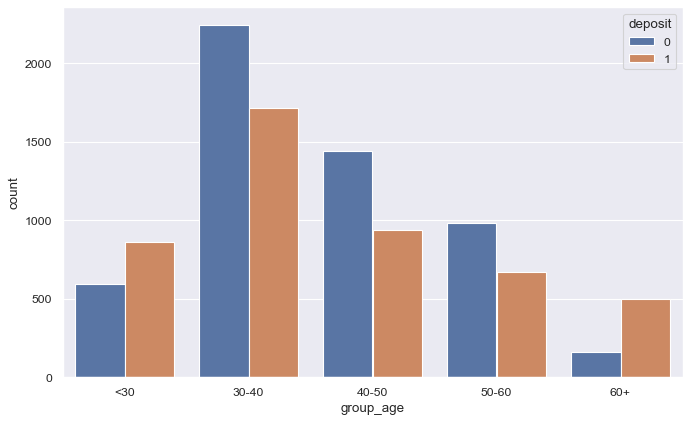

In [343]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df['group_age'] = pd.cut(df.age, [0, 30, 40, 50, 60, 9999], labels = ['<30','30-40','40-50','50-60','60+'], right=False)
plt.figure(figsize=(10, 6), dpi=80)
sns.countplot(data=df, x="group_age", hue="deposit");

### Задания 9 и 10

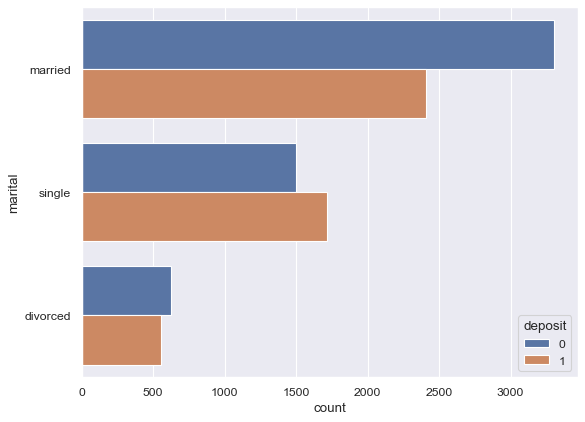

In [344]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(y='marital', hue='deposit', data=df);

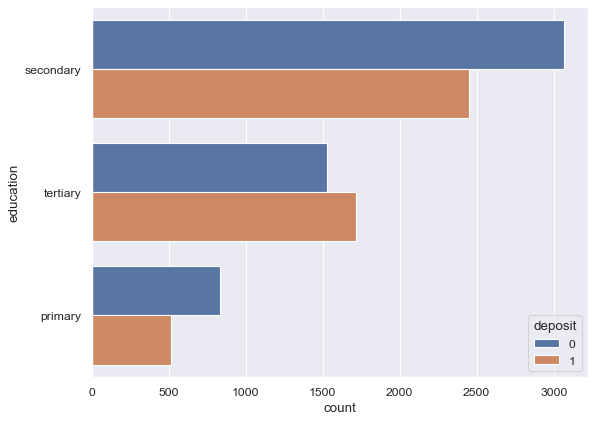

In [345]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
plt.figure(figsize=(8, 6), dpi=80)
sns.countplot(y='education', hue='deposit', data=df);

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

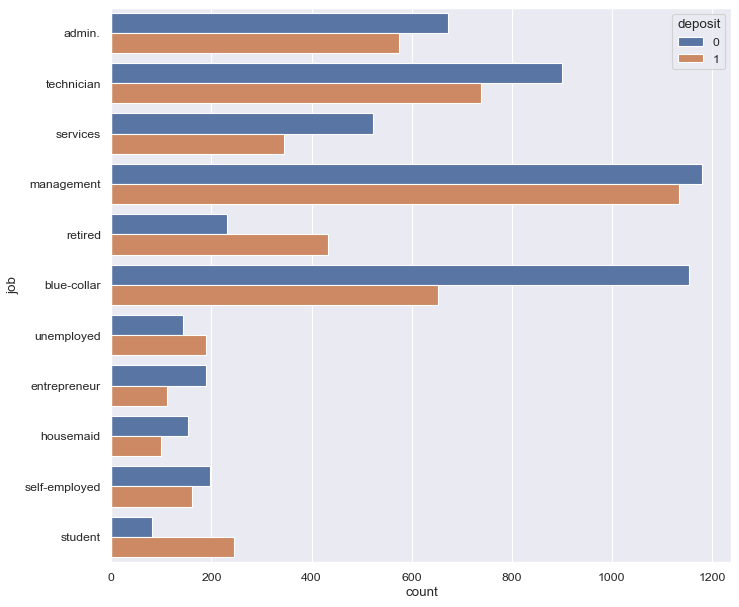

In [346]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
plt.figure(figsize=(10, 9), dpi=80)
sns.countplot(y='job', hue='deposit', data=df);

display(df.groupby('job').job.count().sort_values(ascending=False))

### Задание 11

In [347]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df[df.deposit == 1].pivot_table(
    values='deposit',
    aggfunc='count',
    index='education',
    columns='marital',
)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


In [348]:
df_pivot = df[df.deposit == 1].copy()
pd.crosstab(
    df_pivot.education,
    df_pivot.marital,
    values=df_pivot.deposit,
    aggfunc='count'
)

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


## Часть 3: преобразование данных

### Задание 1

In [349]:
# преобразуйте уровни образования
le = LabelEncoder()
df.education = le.fit_transform(df.education)
df.education.sum()

11995

In [350]:
# обраюб\ботайте также созданную порядковую переменную для возраста
df.group_age = le.fit_transform(df.group_age)

### Задания 2 и 3

**Задание 4.2**
Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной `deposit`.

In [351]:
df.deposit.std().round(3)

0.499

In [352]:
# преобразуйте бинарные переменные в представление из нулей и единиц
col_bin = ['default', 'housing', 'loan']
for i in col_bin:
    df[i] = df[i].apply(lambda x: 1 if x == 'yes' else 0)
df[['default', 'housing', 'loan']].value_counts()

default  housing  loan
0        0        0       4599
         1        0       4003
                  1        773
         0        1        564
1        1        0         63
         0        0         47
                  1         33
         1        1         23
dtype: int64

**Задание 4.3**

Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата

In [353]:
df[['default', 'housing', 'loan']].mean().sum().round(3)

0.635

### Задание 4

In [354]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=True)
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,0,1,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,0,1,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,0,1,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,0,1,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,0,1,0,0,0,0,0,1


### Задания 5 и 6

In [355]:
cor_df = df.corr().round(2)

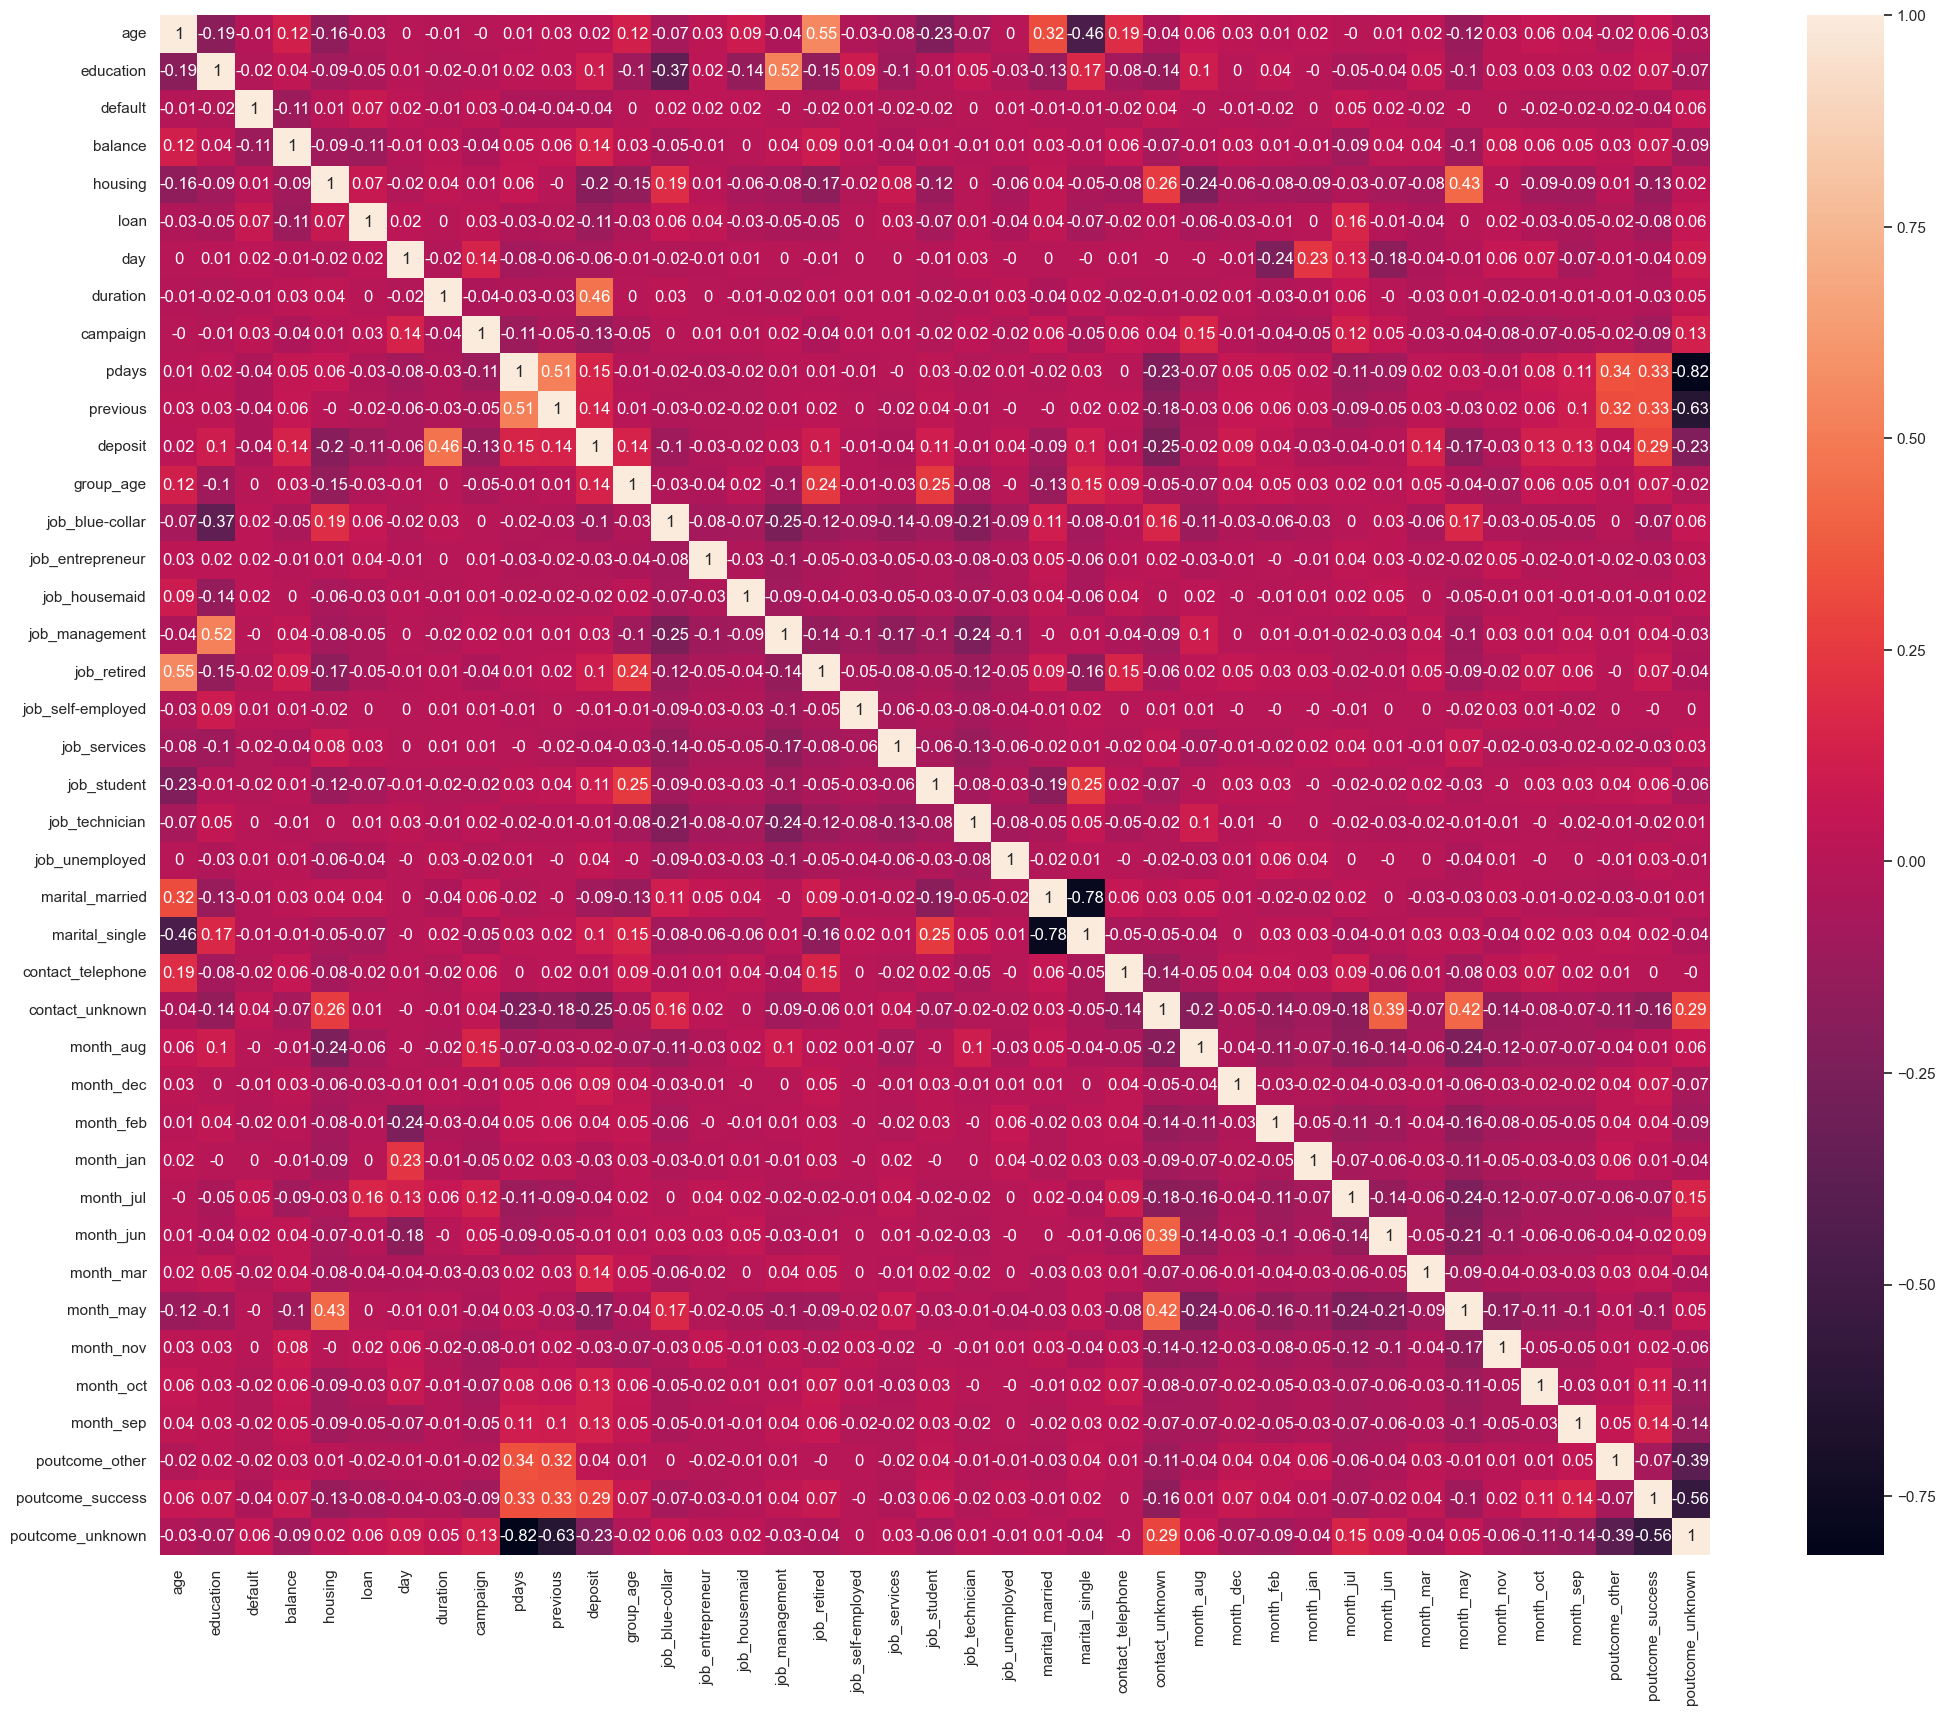

In [356]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.set(rc = {'figure.figsize':(25,20)})
sns.heatmap(cor_df, annot = True);

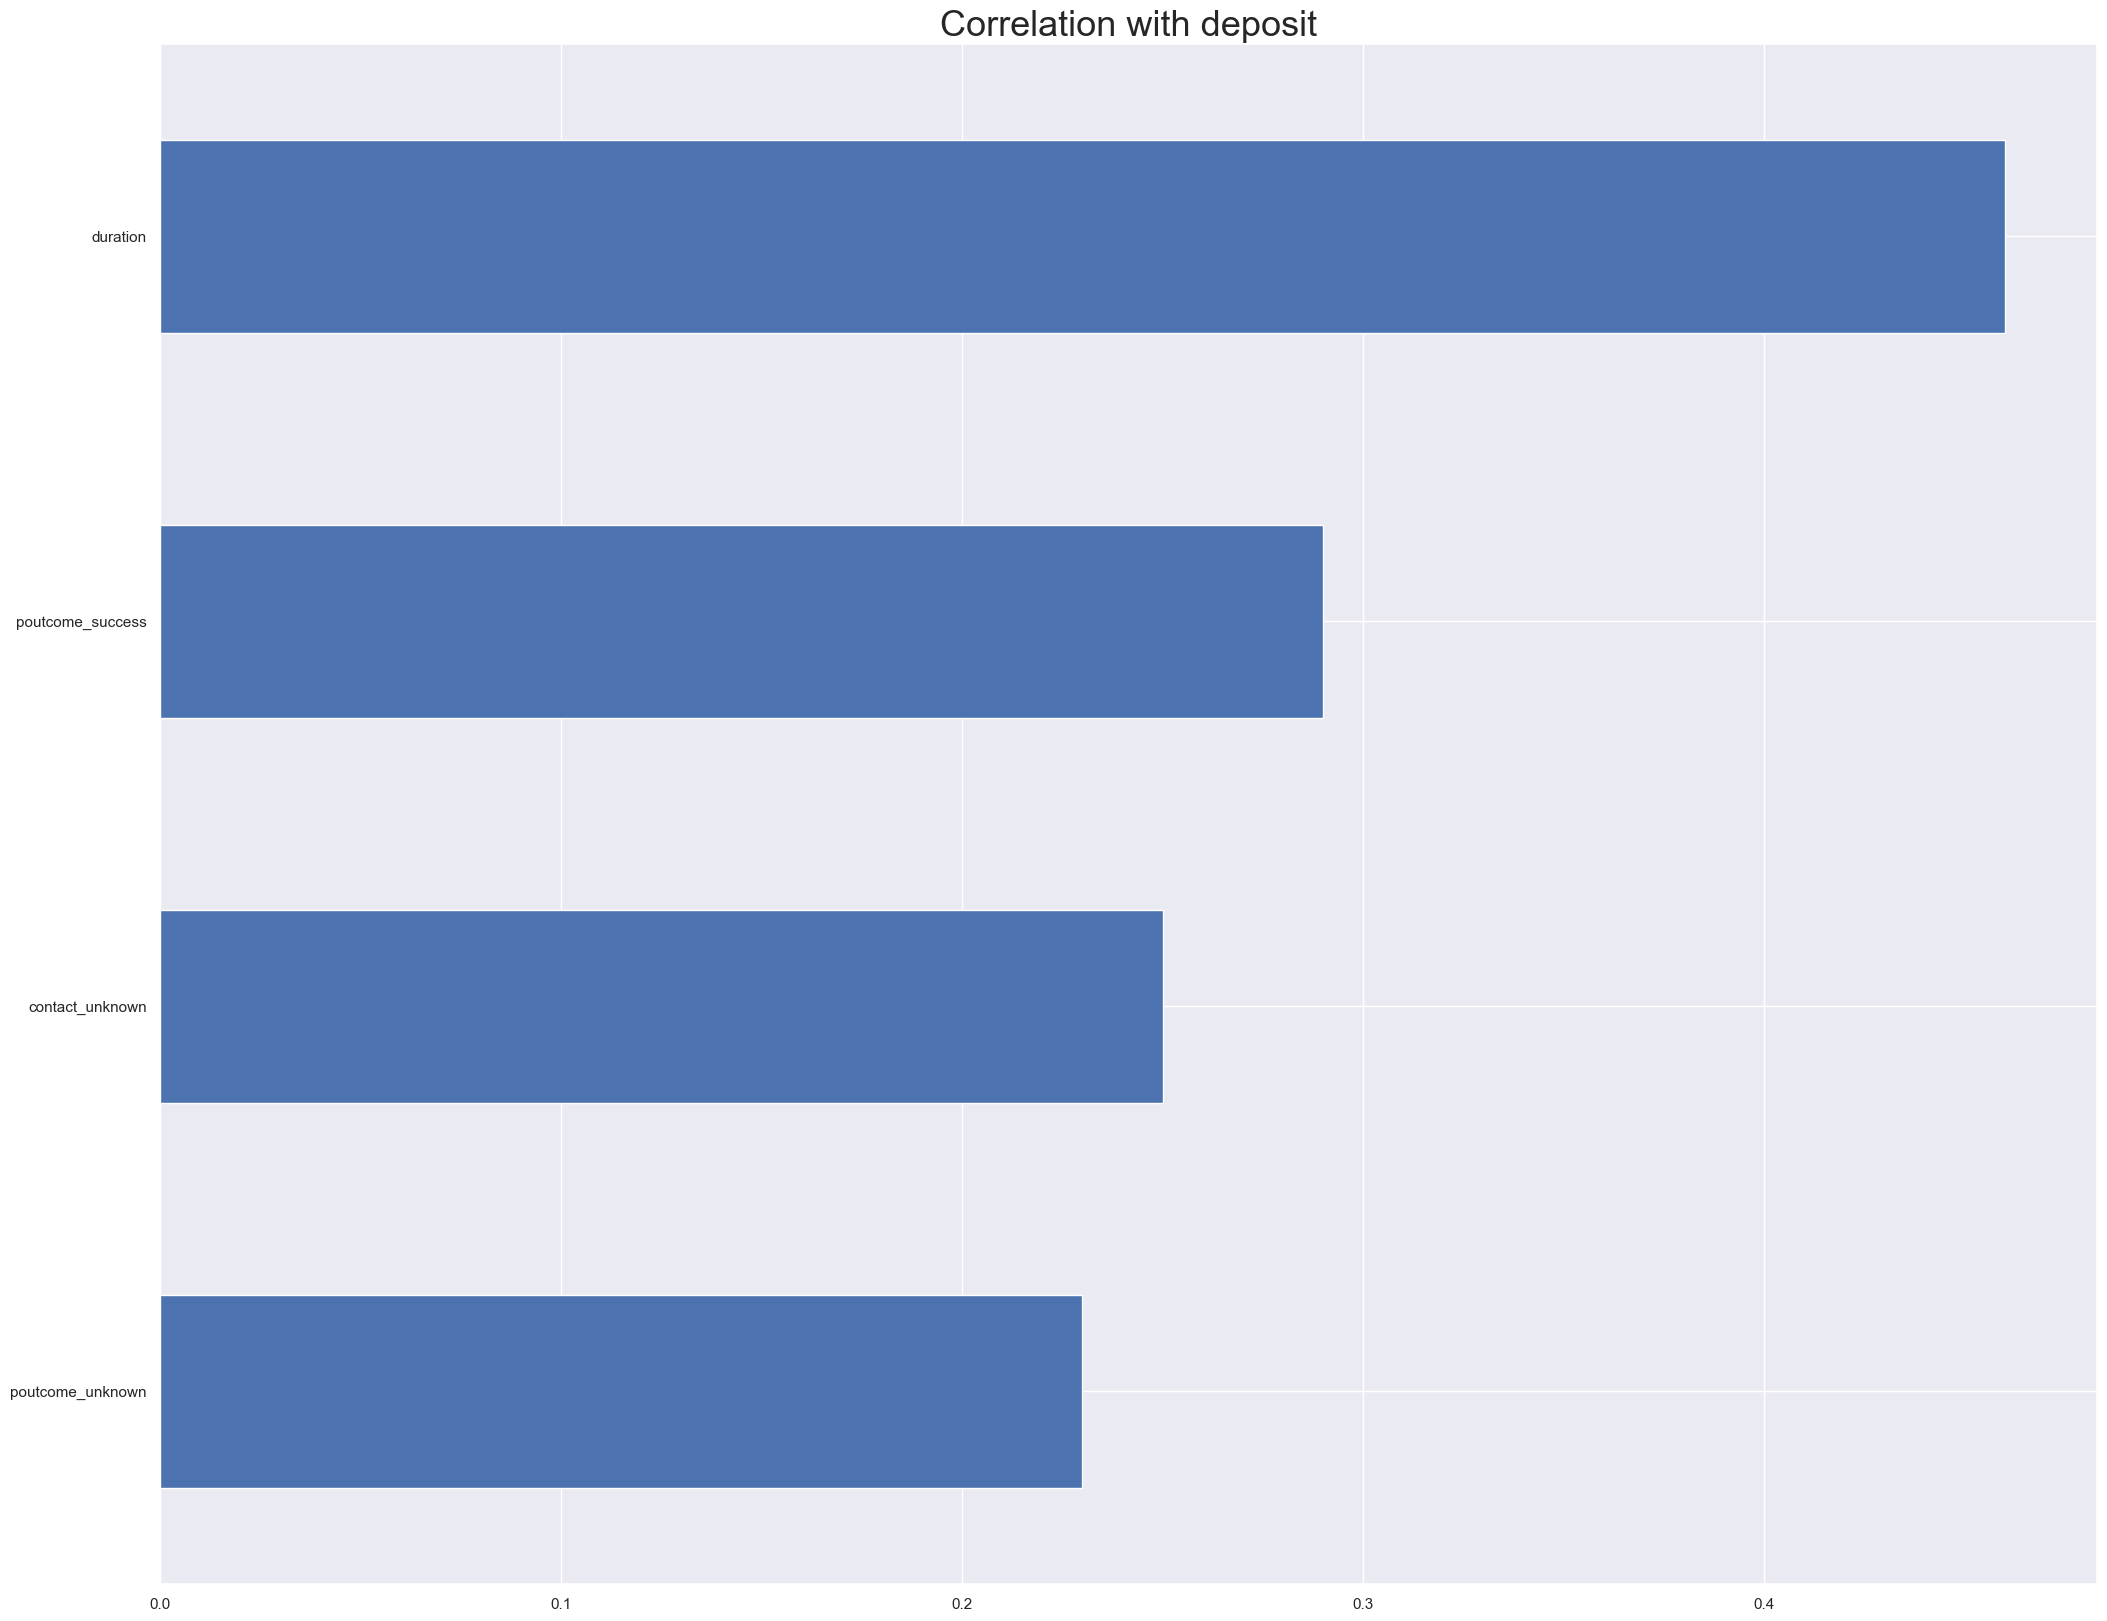

In [357]:
cor_df["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 26)
plt.show()

### Задания 7 и 8

In [418]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [359]:
# рассчитайте необходимые показатели
print(f'Размер тестовй выборки {X_test.shape[0]}')
print('Среднее значение целевой переменной на тестовой выборке {:.2f}'.format(y_test.mean()))

Размер тестовй выборки 3335
Среднее значение целевой переменной на тестовой выборке 0.46


### Задание 9

In [360]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector_kb = SelectKBest(score_func = f_classif, k=15)
selector_kb.fit(X_train, y_train)
 
сol_kb = selector_kb.get_feature_names_out()
col_kb = list(сol_kb)
col_kb
X_train = X_train[сol_kb]
X_test = X_test[сol_kb]


### Задание 10

In [362]:
# нормализуйте данные с помощью minmaxsxaler
scaler_mm = preprocessing.MinMaxScaler()
scaler_mm.fit(X_train)                           
X_train = scaler_mm.transform(X_train)    
X_test = scaler_mm.transform(X_test)

**Задание 4.10**
Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки

In [363]:
print('Cреднее арифметическое для первого предиктора тестовой выборки {:.2f}'.format(X_test[:, 0].mean()))

Cреднее арифметическое для первого предиктора тестовой выборки 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [398]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print(metrics.accuracy_score(y_test, y_test_pred).round(2))

0.81


### Задания 2,3,4

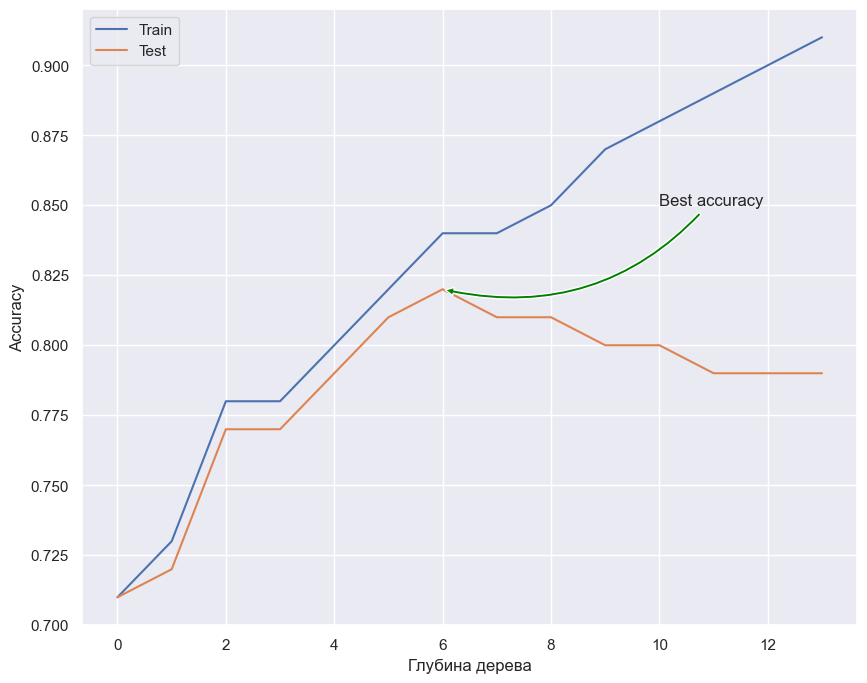

In [413]:
# обучите решающие деревья, настройте максимальную глубину
train_l = []
test_l = []

for i in range(1, 15):
    log_reg_5_2 = tree.DecisionTreeClassifier(
        criterion='entropy',
        random_state=42,
        max_depth = i
    )
    log_reg_5_2.fit(X_train, y_train)
    y_train_pred_5_2 = log_reg_5_2.predict(X_train)
    # print('Глубина дерева {:.0f}'.format(i))
    train_l.append(metrics.accuracy_score(y_train, y_train_pred_5_2).round(2))
    y_test_pred_5_2 = log_reg_5_2.predict(X_test)
    test_l.append(metrics.accuracy_score(y_test, y_test_pred_5_2).round(2))
    
            
fig, ax = plt.subplots(figsize=(10, 8))
ax.annotate('Best accuracy',
            xy=(6, 0.82),
            xytext=(10, 0.85),
            arrowprops=dict(arrowstyle='simple',
                            facecolor='green',
                            connectionstyle='arc3, rad=-0.3')
            )
plt.plot(train_l)
plt.plot(test_l)
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Test']);


### Задание 5

In [385]:
# подберите оптимальные параметры с помощью gridsearch

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

grid_search = GridSearchCV(tree.DecisionTreeClassifier(criterion='entropy'), 
                        parameters,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

grid_search.fit(X_train, y_train)
y_test_pred_5_5 = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_5_5)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [388]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train, y_train)

y_test_pred_6_1 = rf.predict(X_test)
print(f'Accuracy - {metrics.accuracy_score(y_test, y_test_pred_6_1).round(2)}')
print(f'Recall - {metrics.recall_score(y_test, y_test_pred_6_1).round(2)}')

Accuracy - 0.83
Recall - 0.84


### Задания 2 и 3

In [391]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train, y_train)

y_test_pred_6_2 = gb.predict(X_test)
print(f'F1-score GBoosting - {metrics.f1_score(y_test, y_test_pred_6_2).round(2)}')
print(f'Accuracy GBoosting - {metrics.accuracy_score(y_test, y_test_pred_6_1).round(2)}')
print(f'Recall GBoosting - {metrics.recall_score(y_test, y_test_pred_6_1).round(2)}')
print(f'F1-score RForest - {metrics.f1_score(y_test, y_test_pred_6_1).round(2)}')


F1-score GBoosting - 0.82
Accuracy GBoosting - 0.83
Recall GBoosting - 0.84
F1-score RForest - 0.82


### Задание 4

In [415]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=7,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42, 
        max_iter=1000 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(
        solver='sag',
        random_state=42, 
        max_iter=1000
    )
)
stack.fit(X_train, y_train)

y_pred_6_4 = stack.predict(X_test)
# Посмотрим на основные метрики классификации
print(metrics.classification_report(y_test, y_pred_6_4))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

In [426]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier(random_state=42)
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

In [425]:
X_train.columns

Index(['age', 'education', 'default', 'balance', 'housing', 'loan', 'day',
       'duration', 'campaign', 'pdays', 'previous', 'group_age',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'contact_telephone', 'contact_unknown', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [427]:
selector.ranking_

array([ 6, 18, 37,  7,  3, 13, 12,  1, 16,  2, 23,  4, 31, 32, 33, 30, 34,
       29, 35, 27, 36, 25, 24, 26, 38,  1, 22, 20, 15, 21, 14,  9,  5, 11,
       17,  8, 10, 28,  1, 19])

### Задания 6,7,8

In [429]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)
rfc = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
rfc.fit(X_train, y_train)
y_test_pred_op = rfc.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_op)))

[I 2023-05-05 15:32:44,103] A new study created in memory with name: RandomForestClassifier
[I 2023-05-05 15:32:48,624] Trial 0 finished with value: 0.8934654691855064 and parameters: {'n_estimators': 170, 'max_depth': 24, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8934654691855064.
[I 2023-05-05 15:32:51,767] Trial 1 finished with value: 0.870962756915469 and parameters: {'n_estimators': 167, 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8934654691855064.
[I 2023-05-05 15:32:54,079] Trial 2 finished with value: 0.873282914029943 and parameters: {'n_estimators': 120, 'max_depth': 28, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8934654691855064.
[I 2023-05-05 15:32:58,134] Trial 3 finished with value: 0.9576005025125628 and parameters: {'n_estimators': 133, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9576005025125628.
[I 2023-05-05 15:33:04,171] Trial 4 finished with value: 0.8602217710448227 and parameters: {'n_

f1_score на тестовом наборе: 0.84


In [430]:
print('Accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_op)))

Accuracy на тестовом наборе: 0.85


In [431]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [432]:
# График важности гиперпараметров
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [433]:
# График контура отношений гиперпараметров
optuna.visualization.plot_contour(study,
                                  params=["max_depth", "n_estimators"],
                                  target_name="f1_score"
                                  )